In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
!pip install classification_models

  Created wheel for classification-models: filename=classification_models-0.1-cp36-none-any.whl size=4755 sha256=cf0e18d28cb7c39bfc8b0838f9dcf3f402e7f944fc24c6285cf7f5c3330d7c52
  Stored in directory: /root/.cache/pip/wheels/50/b5/89/45f4964eec60d855f1ac0d91cefcbf76f0d6547f0acf8c4fe4
Successfully built classification-models


# Introduce




**Dataset**
 
 The Datasets contains 402 images in 4 folders as 4 classes: NinhThuan_Green, NinhThuan_Red, China_Red, China_Green. However, the China_Red and China_Green contains only 32 images so the datasets is embalanced. 

Each image in each folder has the label as part of the foldername. 



**Method**

  For the solution of this problem we will use a pre-trained model, VGG16, Resnet18, replacing only the last layer.

# Import the Libraries and set parameters



In [1]:
import os
# import glob2
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import  Flatten, Dense, Dropout, Input, GlobalAveragePooling2D
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
import tensorflow.keras.backend as K
#from tensorflow.keras.utils import Sequence, to_categorical
import numpy as np
import random
import pickle
from imutils import paths
import cv2
from matplotlib import pyplot as plt
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import MultiLabelBinarizer,LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score
from tqdm import *

# thêm 1 số callback
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard

In [3]:
INPUT_SHAPE = (224, 224 ,3)
N_CLASSES = 4
EPOCHS = 30
INIT_LR = 1e-3
BATCH_SIZE = 32
opt = Adam(lr=INIT_LR)
# opt1=SGD(0.0001)

In [4]:
path = '/content/gdrive/My Drive/ML4Grapes/GrapesClassifcation/datasets'

# Read the Data

In [50]:
# Lấy path data
imagePaths = sorted(list(paths.list_images(path)))


In [6]:
#Tách tên classes từ đường dẫn
classes = [path.split("/")[-2] for path in imagePaths]

In [8]:
data = []
labels = []

In [9]:
# Đọc data đầu vào từ imagePaths và gán label cho data 
for imagePath in imagePaths:
    image = cv2.imread(imagePath)
    #Resize ảnh 224X224
    image = cv2.resize(image, (224, 224))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = img_to_array(image)
    data.append(image)
    #gán dữ liệu labels
    label = imagePath.split(os.path.sep)[-2]
    labels.append(label)

In [10]:
# scale [0, 1]
data = np.array(data, dtype="float")/255.0

In [11]:
# Chuyển label của ảnh thành ma trận nhị phân
#mlb = MultiLabelBinarizer()
mlb = LabelBinarizer()
y = mlb.fit_transform(labels)

In [12]:
 mlb.classes_

array(['China_Green', 'China_Red', 'NinhThuan_Green', 'NinhThuan_Red'],
      dtype='<U15')

In [13]:
# Lữu trữ mlb.pkl file
f = open('mlb.pkl', "wb")
f.write(pickle.dumps(mlb))
f.close()

# EDA

In [14]:
def _imread(path):
    img = cv2.imread(path)
    imgRGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return imgRGB

In [ ]:
cn_red = "./datasets/China_Red"
cn_green = "./datasets/China_Green"
nt_red = "./datasets/NinhThuan_Red"
nt_green = "./datasets/NinhThuan_Green"

grape_cn_red = _imread(cn_red + "/tq3.jpg")
grape_cn_green = _imread(cn_green + "/nhotqqq.png")
grape_nt_red = _imread(nt_red + "/NinhThuan_Red_001.jpg")
grape_nt_green = _imread(nt_green + "/NinhThuan_Green_120.jpg")

(([], <a list of 0 Text xticklabel objects>),
 ([], <a list of 0 Text yticklabel objects>))

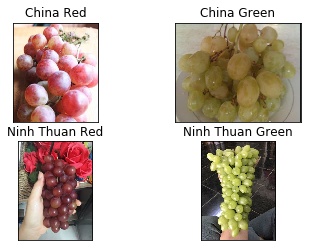

In [ ]:
plt.subplot(2,2,1)
plt.imshow(grape_cn_red)
plt.title("China Red")
plt.xticks([]), plt.yticks([])

plt.subplot(2,2,2)
plt.imshow(grape_cn_green)
plt.title("China Green")
plt.xticks([]), plt.yticks([])

plt.subplot(2,2,3)
plt.imshow(grape_nt_red)
plt.title("Ninh Thuan Red")
plt.xticks([]), plt.yticks([])

plt.subplot(2,2,4)
plt.imshow(grape_nt_green)
plt.title("Ninh Thuan Green")
plt.xticks([]), plt.yticks([])

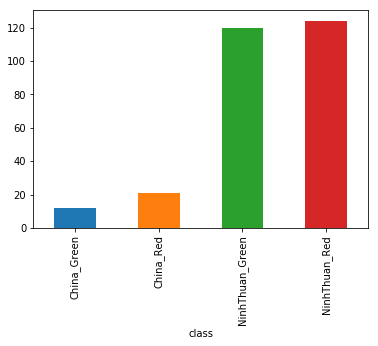

In [ ]:
# Phân tích số lượng data đầu vào của mỗi class
data_fr = pd.DataFrame({'class': classes, 'source':imagePaths})
data_fr.groupby('class').source.count().plot.bar()


# Modeling

## Prepare the model



In [15]:
# Split datasets
(X_train, X_test, y_train, y_test) = train_test_split(data, y, test_size=0.4, random_state=42,stratify=y,shuffle=True)
(X_test, X_val, y_test, y_val) = train_test_split(X_test, y_test, test_size=0.5, random_state=42,stratify=y_test,shuffle=True)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
print(X_val.shape, y_val.shape)

(166, 224, 224, 3) (166, 4)
(55, 224, 224, 3) (55, 4)
(56, 224, 224, 3) (56, 4)


In [16]:
aug = ImageDataGenerator(rotation_range=15, width_shift_range=0.1,
                        height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,
                        horizontal_flip=True, fill_mode="nearest")

In [17]:
# Load model VGG 16 của ImageNet dataset, include_top=False để bỏ phần Fully connected layer ở cuối
base_model=VGG16(weights= 'imagenet', include_top=False, input_tensor=Input(shape=(224,224,3)))
# Thêm cái layer
# Lấy output của ConvNet trong VGG16
x = base_model.output

# # Flatten trước khi dùng FCs
# x = Flatten(name='flatten')(x)
# ít data -> nên xài ít parametter -> GlobalAveragePooling2D
x = GlobalAveragePooling2D()(x)

# Thêm FC
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)

# Output layer với sigmoid activation
out = Dense(4, activation='softmax')(x)

# Xây dựng model bằng việc nối ConvNet của VGG16 và output layer
model = Model(inputs=base_model.input, outputs=out)


58892288/58889256 [==============================] - 0s 0us/step


In [18]:
# Freeze backbone of model and train with large LR
for layer in base_model.layers:
    layer.trainable = False

model.compile(loss="categorical_crossentropy", optimizer=Adam(lr=INIT_LR), metrics=["accuracy"])
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

## Train model with pretrain VGG16


In [19]:
# warm up the network with 2 epoch
history1 = model.fit_generator(
    aug.flow(X_train, y_train, batch_size=BATCH_SIZE),
    validation_data=(X_val, y_val),
    steps_per_epoch=len(X_train) // BATCH_SIZE,
    epochs=2, verbose=1)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/2
5/5 [==============================] - 4s 744ms/step - loss: 1.1860 - accuracy: 0.4403 - val_loss: 1.0756 - val_accuracy: 0.4286
Epoch 2/2
5/5 [==============================] - 2s 306ms/step - loss: 1.0778 - accuracy: 0.5063 - val_loss: 1.0665 - val_accuracy: 0.4464


In [20]:
score = model.evaluate(X_val, y_val, verbose=0)
print('Validation loss:', score[0])
print('Validation accuracy:', score[1])

Validation loss: 1.0665000677108765
Validation accuracy: 0.4464285671710968


### Unfreeze some last CNN layer

In [35]:
# unfreeze all layers:
for layer in model.layers[-4:]:
    layer.trainable = True

model.compile(loss="categorical_crossentropy", optimizer=Adam(lr=INIT_LR/10), metrics=["accuracy"])
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

In [36]:
for layer in model.layers:
    print('Layer: {} ; Trainable: {}'.format(layer, layer.trainable))

Layer: <tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f9b082c2160> ; Trainable: False
Layer: <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f9b0826b208> ; Trainable: False
Layer: <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f9b0826b588> ; Trainable: False
Layer: <tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f9b0826b940> ; Trainable: False
Layer: <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f9b0823f630> ; Trainable: False
Layer: <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f9b00408160> ; Trainable: False
Layer: <tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f9b004088d0> ; Trainable: False
Layer: <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f9b0040f0f0> ; Trainable: False
Layer: <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f9b0040ff28> ; Trainable: False
Layer: <tensorflow.python.keras.layers.convolutional.

In [37]:
callbacks = [ReduceLROnPlateau(monitor='val_loss',
                               factor=0.5,
                               patience=2,
                               verbose=1,
                               epsilon=1e-5),
             ModelCheckpoint(monitor='val_loss',
                             filepath='./model_grapes_multitask_learning.hdf5',
                             save_best_only=True,
                             save_weights_only=True)]


history2 = model.fit_generator(
    aug.flow(X_train, y_train, batch_size=BATCH_SIZE),
    validation_data=(X_val, y_val),
    steps_per_epoch=len(X_train) // BATCH_SIZE,
    epochs=EPOCHS, verbose=1,
    callbacks=callbacks)

Epoch 1/30
5/5 [==============================] - 2s 339ms/step - loss: 0.0956 - accuracy: 0.9776 - val_loss: 0.4722 - val_accuracy: 0.8571
Epoch 2/30
5/5 [==============================] - 2s 341ms/step - loss: 0.0564 - accuracy: 0.9750 - val_loss: 0.4616 - val_accuracy: 0.8571
Epoch 3/30
5/5 [==============================] - 2s 342ms/step - loss: 0.0603 - accuracy: 0.9812 - val_loss: 0.4523 - val_accuracy: 0.8571
Epoch 4/30
5/5 [==============================] - 2s 362ms/step - loss: 0.0621 - accuracy: 0.9627 - val_loss: 0.4462 - val_accuracy: 0.8750
Epoch 5/30
5/5 [==============================] - 1s 271ms/step - loss: 0.0615 - accuracy: 0.9776 - val_loss: 0.4465 - val_accuracy: 0.8750
Epoch 6/30
4/5 [=======================>......] - ETA: 0s - loss: 0.0459 - accuracy: 0.9844
Epoch 00006: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
5/5 [==============================] - 1s 258ms/step - loss: 0.0440 - accuracy: 0.9851 - val_loss: 0.4490 - val_accuracy: 0.8750

In [38]:
model.save("model_grapes_multitask_learning.h5")

In [40]:
# load best epoch
model.load_weights('/content/model_grapes_multitask_learning.h5')

In [41]:
score = model.evaluate(X_val, y_val, verbose=0)
print('Validation loss:', score[0])
print('Validation accuracy:', score[1])

Validation loss: 0.42316102981567383
Validation accuracy: 0.8928571343421936


## Show accuracy and loss

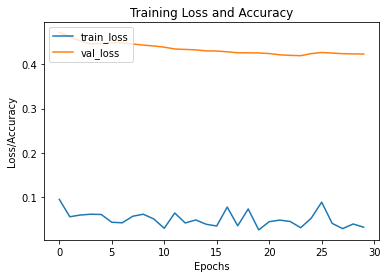

In [42]:
# Show VGG16 Training Loss and Accuracy with some layers unfreeze
plt.figure()
N = EPOCHS
plt.plot(np.arange(0, N), history2.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history2.history["val_loss"], label="val_loss")
# plt.plot(np.arange(0, N), history2.history["accuracy"], label="train_acc")
# plt.plot(np.arange(0, N), history2.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper left")

## F1-score for VGG16


In [43]:
def find_best_fixed_threshold(preds, targs, do_plot=False):
    score = []
    thrs = np.arange(0, 0.95, 0.01)
    for thr in tqdm(thrs):
        score.append(f1_score(targs, (preds >= thr).astype(int), average='macro' ))
    score = np.array(score)
    pm = score.argmax()
    best_thr, best_score = thrs[pm], score[pm].item()
    print('thr= ', best_thr, ' F1= ', best_score)
    return best_thr, best_score

In [44]:
y_pred_val = model.predict(X_val,batch_size=10,verbose=1)

# search best threshold when making a decision
best_thr, best_score = find_best_fixed_threshold(y_pred_val, y_val, do_plot=False)

6/6 [==============================] - 0s 41ms/step


100%|██████████| 95/95 [00:00<00:00, 642.60it/s]

thr=  0.25  F1=  0.7596153846153846


In [45]:
# f1-score in train
y_pred_train = model.predict(X_train,batch_size=10,verbose=1)
y_pred_train = (y_pred_train >= best_thr)
model_f1_score = f1_score(y_train, y_pred_train, average='macro')
print('f1 score on train: ', model_f1_score)

17/17 [==============================] - 1s 54ms/step
f1 score on train:  0.9620978120978121


In [46]:
# f1-score in validset
y_pred_val = (y_pred_val >= best_thr)
model_f1_score= f1_score(y_val, y_pred_val, average='macro')
print('f1 score on valid: ',model_f1_score)

f1 score on valid:  0.7596153846153846


In [47]:
#F1-score trong sklearn với average='macro' in testset
# Predict bộ test và chuyển sang dạng ma trận nhị phân như y_test
y_pred = model.predict(X_test,batch_size=10,verbose=1)
y_pred = (y_pred >= best_thr)
model_f1_score = f1_score(y_test, y_pred,average='macro')
print('f1 score on test: ',model_f1_score)

6/6 [==============================] - 1s 140ms/step
f1 score on test:  0.9622222222222222


# Predict the test dataset

In [48]:
# Predict bộ test và chuyển sang dạng ma trận nhị phân như y_test
y_pred = model.predict(X_test,batch_size=10,verbose=1)
y_pred = (y_pred >= best_thr)

6/6 [==============================] - 0s 58ms/step


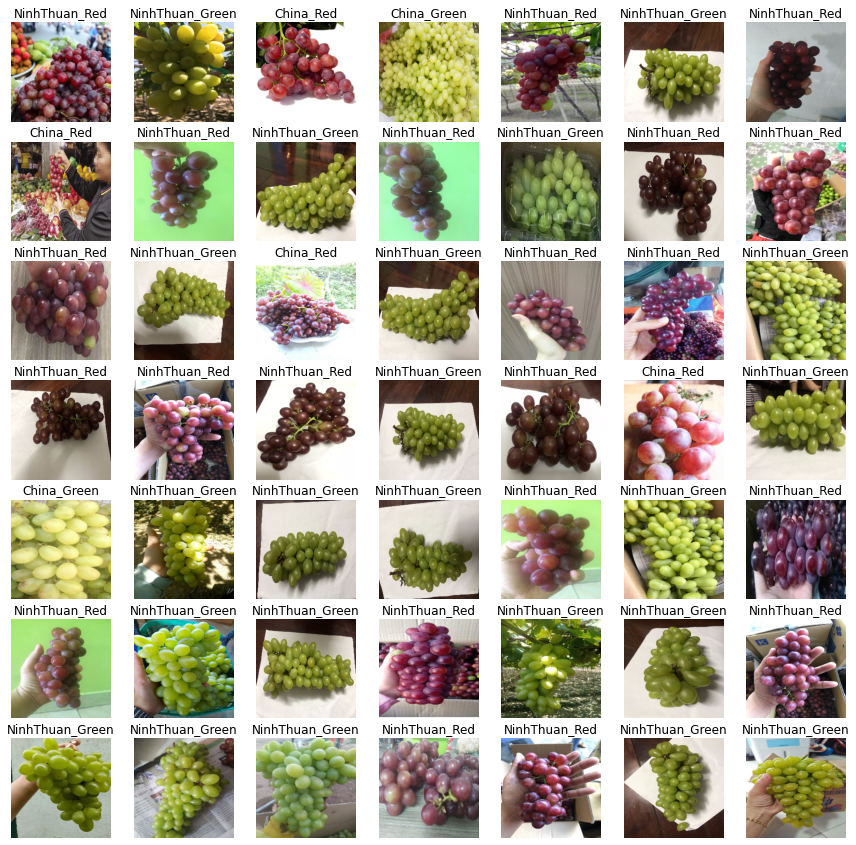

In [49]:
f, ax = plt.subplots(7,7, figsize=(15,15))
for i in range(0,49):
    arr=y_pred[i]
    orig=X_test[i]
    for j in range(0, len(arr)):
        if arr[j] == 1: 
            str_predicted="{}".format(mlb.classes_[j])
    ax[i//7, i%7].imshow(orig)
    ax[i//7, i%7].axis('off')
    ax[i//7, i%7].set_title("{}".format(str_predicted))    
plt.show()